# EV Disconnection Times: Data Exploration

## 0. Imports

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

## 1. Load and preprocess data

In [3]:
# Load the JSON file
file_path = '../data/raw/acndata_sessions.json'
with open(file_path, 'r') as file:
    raw_data = json.load(file)

# Extract the list of sessions
data = pd.json_normalize(raw_data['_items'])  # Flatten the nested structure

# Convert time columns to datetime
data['disconnectTime'] = pd.to_datetime(data['disconnectTime'], errors='coerce')

# Drop rows with invalid disconnectTime
data = data.dropna(subset=['disconnectTime'])

# Adjust timezone to local time
# Assuming 'timezone' field has strings like "America/Los_Angeles"
data['localDisconnectTime'] = data.apply(
    lambda row: row['disconnectTime'].tz_localize('UTC').astimezone(pytz.timezone(row['timezone'])),
    axis=1
)

In [4]:
# Filter for weekdays based on local time
data['weekday'] = data['localDisconnectTime'].dt.weekday
weekday_data = data[data['weekday'] < 5].copy()  # Monday (0) to Friday (4)

## 2. Disconnection Time Empirical Distribution

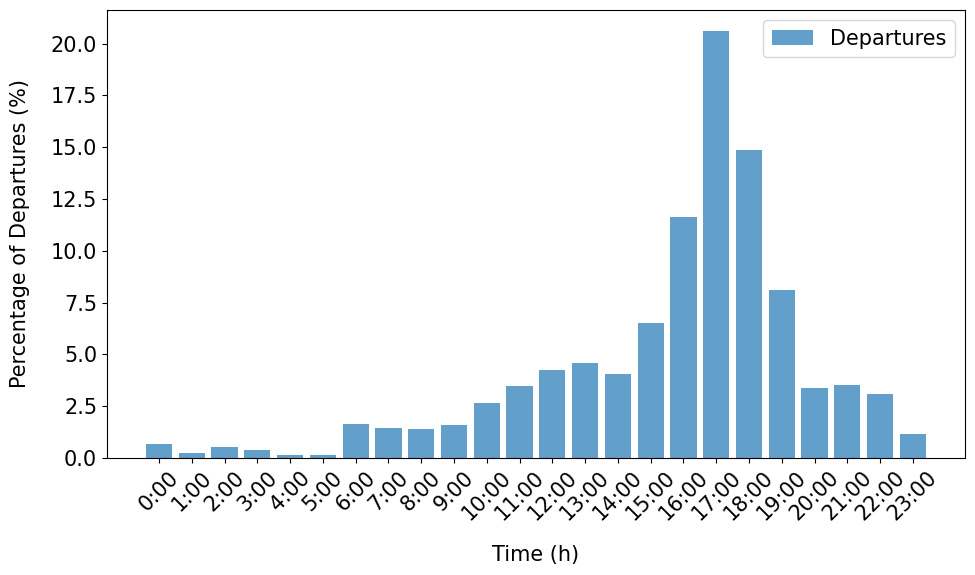

In [9]:
import matplotlib.pyplot as plt

# Set global font size to 15
plt.rcParams.update({'font.size': 15})

# Extract hour of departure based on local time
weekday_data.loc[:, 'hour'] = weekday_data['localDisconnectTime'].dt.hour

# Count departures by hour
departure_counts = weekday_data['hour'].value_counts().sort_index()

# Calculate percentages
departure_percentages = (departure_counts / departure_counts.sum()) * 100

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(departure_percentages.index, departure_percentages, alpha=0.7, label='Departures')
plt.xticks(range(24), [f'{hour}:00' for hour in range(24)], rotation=45)
plt.xlabel('Time (h)', labelpad=15)
plt.ylabel('Percentage of Departures (%)', labelpad=15)
# Title removed as per request
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

## 3. Gaussian Mixture Model Fitting

### Fit the Model

In [6]:
from sklearn.mixture import GaussianMixture
import pickle
import numpy as np
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"


# Prepare data for GMM
departure_hours = weekday_data['hour'].values.reshape(-1, 1)  # GMM expects 2D array

# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(departure_hours)

# Save the GMM model
# model_path = '../analyses/gmm_departure_model.pkl'
# with open(model_path, 'wb') as model_file:
#     pickle.dump(gmm, model_file)

# print(f"Model saved to {model_path}")

GaussianMixture(n_components=3, random_state=42)

### Visualize learned Model

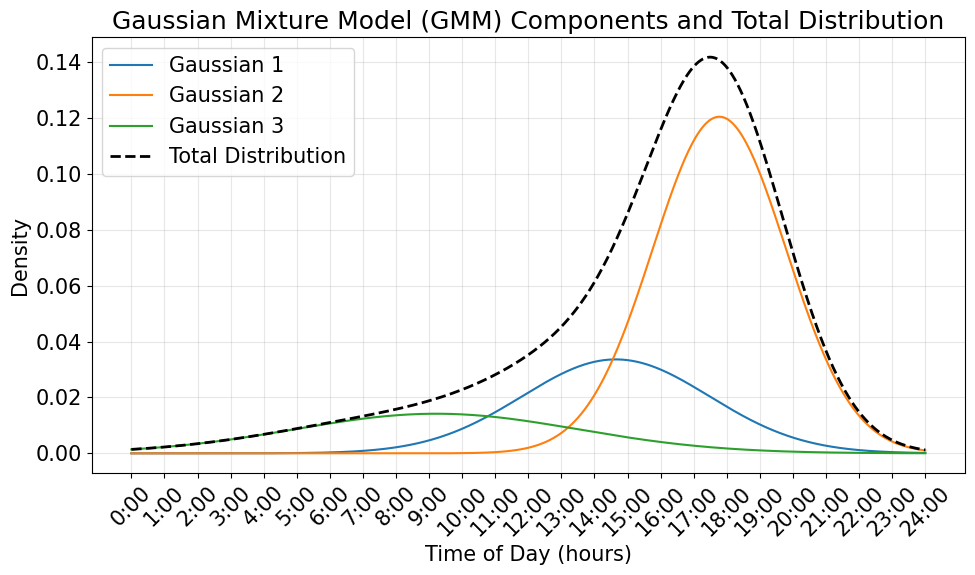

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate a range of values for plotting
x = np.linspace(0, 24, 1000)  # Hours from 0 to 24
x_reshaped = x.reshape(-1, 1)  # GMM expects 2D input

# Extract GMM parameters
weights = gmm.weights_
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each Gaussian component
for i in range(len(weights)):
    component = weights[i] * norm.pdf(x, loc=means[i], scale=np.sqrt(covariances[i]))
    plt.plot(x, component, label=f'Gaussian {i+1}')

# Plot the total distribution
total_distribution = np.sum([weights[i] * norm.pdf(x, loc=means[i], scale=np.sqrt(covariances[i]))
                              for i in range(len(weights))], axis=0)
plt.plot(x, total_distribution, label='Total Distribution', color='black', linestyle='--', linewidth=2)

# Add plot details
plt.title('Gaussian Mixture Model (GMM) Components and Total Distribution')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Density')
plt.xticks(range(25), [f'{hour}:00' for hour in range(25)], rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

### Plot samples of the learned Distribution

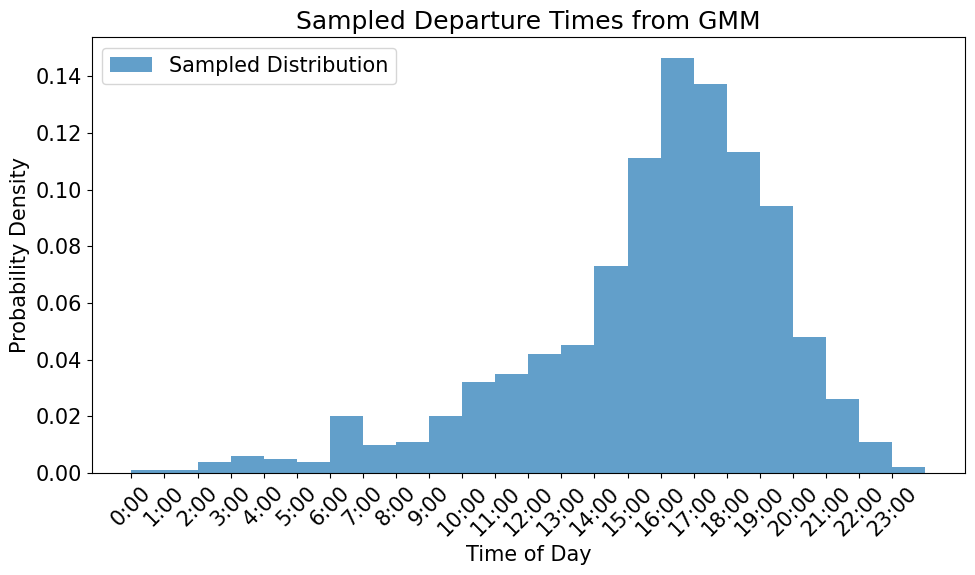

In [8]:
# Sample from the model
samples, _ = gmm.sample(1000)  # Generate 1000 samples
sample_hours = samples.flatten()

# Plot the sampled distribution
plt.figure(figsize=(10, 6))
plt.hist(sample_hours, bins=24, range=(0, 24), alpha=0.7, density=True, label='Sampled Distribution')
plt.xticks(range(24), [f'{hour}:00' for hour in range(24)], rotation=45)
plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Sampled Departure Times from GMM')
plt.legend()
plt.tight_layout()